In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
titanic = sns.load_dataset('titanic')
titanic = titanic.drop(['deck', 'embark_town', 'embarked', 'alive'], axis=1)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    891 non-null    int64   
 1   pclass      891 non-null    int64   
 2   sex         891 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        891 non-null    float64 
 7   class       891 non-null    category
 8   who         891 non-null    object  
 9   adult_male  891 non-null    bool    
 10  alone       891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(2)
memory usage: 58.6+ KB


<Axes: xlabel='survived'>

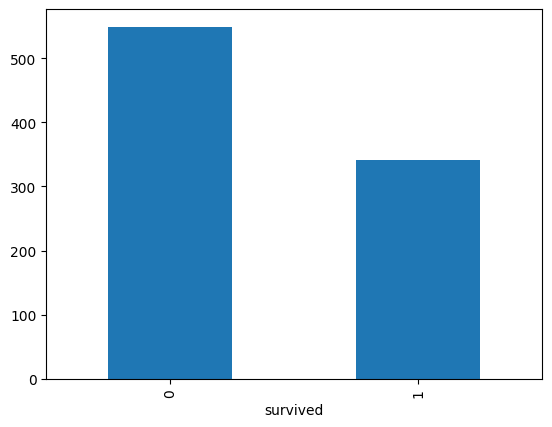

In [28]:
X = titanic.drop('survived', axis=1)
y = titanic['survived']

titanic['survived'].value_counts().plot(kind='bar')

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_feats = X.select_dtypes(include='number').columns
cat_feats = X.select_dtypes(include=['object', 'category']).columns

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
}


In [31]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

In [32]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['sex', 'class', 'who'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, 20, None],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



<Axes: >

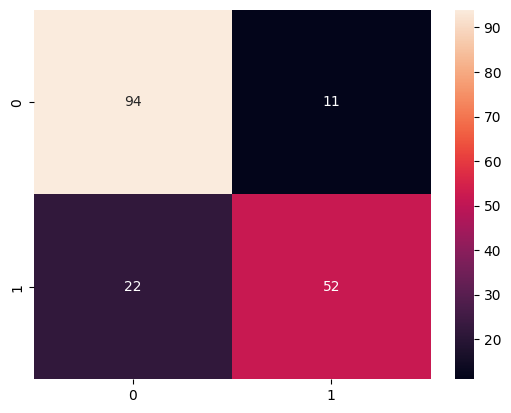

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')

<BarContainer object of 13 artists>

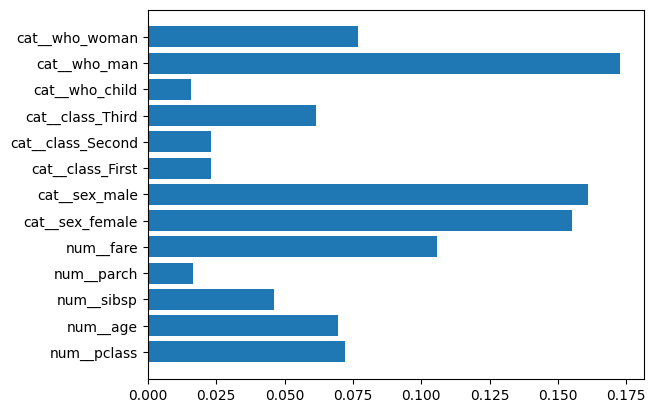

In [35]:
best_model = model.best_estimator_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
feature_importances = model.best_estimator_[-1].feature_importances_

plt.barh(feature_names, feature_importances)

In [37]:
print(f'Accuracy: {model.score(X_test, y_test):.2f}')

Accuracy: 0.82


In [38]:
from sklearn.linear_model import LogisticRegression

pipeline.set_params(classifier=LogisticRegression())

param_grid = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': ['balanced', None]
}

model.param_grid = param_grid
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['sex', 'class', 'who'], dtype='object'))])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='accuracy')

In [40]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



<Axes: >

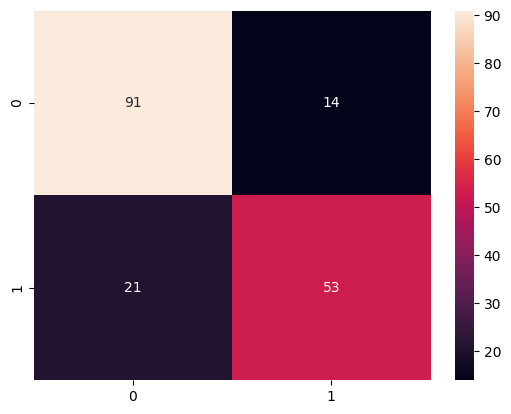

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')